<a href="https://colab.research.google.com/github/Mikanribu/doctoplant_tensorflow/blob/main/cnn_tensorflow_doctoplant_data_augmented_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Doctoplant - Discover diseases on leaves photos.

### CNN model with TensorFlow using GPU

## 1. Environment preparation
1. Make sure TensorFlow is installed 
2. Check if Drive is connected
3. Unzip dataset
4. Check if we are connected to GPU

It's faster to copy the Dataset from our own Drive to Collab environment. And from there, unzip the Dataset and start working on it.

It takes overall less than 5 minutes to copy and unzip the whole Dataset, so it worth it to follow this process.

In [1]:
# Import TensorFlow into collab
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.4.1


In [2]:
# Import Drive (to execute only ONCE)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Unzip Background images (to execute only ONCE)
!unzip -u '/content/sample_data/bckgrnd_img.zip' -d '/content/sample_data'

Archive:  /content/sample_data/bckgrnd_img.zip
  inflating: /content/sample_data/bckgrnd_img/Raspberry.jpg  
  inflating: /content/sample_data/__MACOSX/bckgrnd_img/._Raspberry.jpg  
  inflating: /content/sample_data/bckgrnd_img/Corn_(maize).jpg  
  inflating: /content/sample_data/__MACOSX/bckgrnd_img/._Corn_(maize).jpg  
  inflating: /content/sample_data/bckgrnd_img/Peach.jpg  
  inflating: /content/sample_data/__MACOSX/bckgrnd_img/._Peach.jpg  
  inflating: /content/sample_data/bckgrnd_img/Squash.jpg  
  inflating: /content/sample_data/__MACOSX/bckgrnd_img/._Squash.jpg  
  inflating: /content/sample_data/bckgrnd_img/Potato.jpg  
  inflating: /content/sample_data/__MACOSX/bckgrnd_img/._Potato.jpg  
  inflating: /content/sample_data/bckgrnd_img/Blueberry.jpg  
  inflating: /content/sample_data/__MACOSX/bckgrnd_img/._Blueberry.jpg  
  inflating: /content/sample_data/bckgrnd_img/Cherry_(including_sour).jpg  
  inflating: /content/sample_data/__MACOSX/bckgrnd_img/._Cherry_(including_sour).

In [4]:
# Unzip Dataset (to execute only ONCE)
!unzip -u "/content/sample_data/Plant_Village_augmented.zip" -d "/content/sample_data"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/sample_data/content/sample_data/plantvillage_dataset_augmented/Tomato___Leaf_Mold/im52784tr1.jpg  
  inflating: /content/sample_data/content/sample_data/plantvillage_dataset_augmented/Tomato___Leaf_Mold/im53016tr0.jpg  
  inflating: /content/sample_data/content/sample_data/plantvillage_dataset_augmented/Tomato___Leaf_Mold/im52621tr0.jpg  
  inflating: /content/sample_data/content/sample_data/plantvillage_dataset_augmented/Tomato___Leaf_Mold/im52883tr0.jpg  
  inflating: /content/sample_data/content/sample_data/plantvillage_dataset_augmented/Tomato___Leaf_Mold/im52736.jpg  
  inflating: /content/sample_data/content/sample_data/plantvillage_dataset_augmented/Tomato___Leaf_Mold/im52707tr1.jpg  
  inflating: /content/sample_data/content/sample_data/plantvillage_dataset_augmented/Tomato___Leaf_Mold/im52260.jpg  
  inflating: /content/sample_data/content/sample_data/plantvillage_dataset_augmen

### Use of GPU

For the purpose of Image Classification, we will use Google GPU to allow us to use Google resources. This will help us to considerably improve the capacity of the laptop to execute ML programs.


In [5]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 2. Code - preparation and training CNN

As we have already performed the DataViz and Data Exploration, we can directly work on our CNN model.
We need:
1. Import the required libraries
2. Create a DataFrame with all information
3. Prepare Data (train/validation)
4. Create Datasets
5. Create CNN model
6. Train our model


### 1. Import the required libraries

In [6]:
# Import required packages
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Create DataFrame 

We will create DataFrame to store required information for our script.

Dataframe composed of:
- List of Plants name (plant)
- List of Plants Categories (category)
- List of images path (img_path) > Features
- List of Plants name + Plants Categories (plant___category) > Labels
- Background of the leaves plant. For other Category no background is required (back_path)

In [7]:
# Get Path to Image folders
IMG_PATH = '/content/sample_data/content/sample_data/plantvillage_dataset_augmented'
BCK_PATH = '/content/sample_data/bckgrnd_img'

# Image size
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)

BUFFER_SIZE = 1000
BATCH_SIZE = 32

In [17]:
# Create Dataframe
def create_info_df(img_dir):
  """
  From the Image directory, create a DataFrame with 5 columns :
    - List of Plants name (plant)
    - List of Plants Categories (category)
    - List of images path (img_path) > Features
    - List of Plants name + Plants Categories (plant___category) > Labels
    - Background of the leaves plant. For other Category no background is required (back_path)

  Return created DataFrame
  """
  list_plants = []
  img_listdir = os.listdir(img_dir) # list of directories
  # Loop through each Plants directories
  for plant in img_listdir:
    url_img = img_dir +'/'+ plant # Get URL

    for img in os.listdir(url_img): # For each image in the Plant directory
      list_plants.append([*plant.split('___'), url_img+'/'+img, plant])

  # Create DataFrame from the list
  df = pd.DataFrame(list_plants, columns=['plant', 'category', 'img_path','plant___category'])
  # Add Background for each plant. If Category "Others", add word "Others" instead of background path
  df['back_path'] = df['plant'].apply(lambda x: x if x == 'Others' else os.path.join(BCK_PATH, x) +'.jpg')

  return df

# Get DF
df_info = create_info_df(IMG_PATH)

# Unique label list:
# This list will be used to define the Prediction of our model
unique_plant_cat = np.unique(df_info['plant___category'].to_numpy())
print("Number of Categories to predict: ", len(unique_plant_cat))
print("DF Info shape: ", df_info.shape)

Number of Categories to predict:  39
DF Info shape:  (111077, 5)


In [16]:
df_info.head()

,plant,category,img_path,plant___category,back_path
0,Raspberry,healthy,/content/sample_data/content/sample_data/plant...,Raspberry___healthy,/content/sample_data/bckgrnd_img/Raspberry/Ras...
1,Raspberry,healthy,/content/sample_data/content/sample_data/plant...,Raspberry___healthy,/content/sample_data/bckgrnd_img/Raspberry/Ras...
2,Raspberry,healthy,/content/sample_data/content/sample_data/plant...,Raspberry___healthy,/content/sample_data/bckgrnd_img/Raspberry/Ras...
3,Raspberry,healthy,/content/sample_data/content/sample_data/plant...,Raspberry___healthy,/content/sample_data/bckgrnd_img/Raspberry/Ras...
4,Raspberry,healthy,/content/sample_data/content/sample_data/plant...,Raspberry___healthy,/content/sample_data/bckgrnd_img/Raspberry/Ras...


In [10]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111077 entries, 0 to 111076
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   plant             111077 non-null  object
 1   category          111077 non-null  object
 2   img_path          111077 non-null  object
 3   plant___category  111077 non-null  object
 4   back_path         111077 non-null  object
dtypes: object(5)
memory usage: 4.2+ MB


In [11]:
df_info['plant___category'].value_counts()

Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
Tomato___Late_blight                                  3818
Squash___Powdery_mildew                               3670
Tomato___Septoria_leaf_spot                           3542
Tomato___Spider_mites Two-spotted_spider_mite         3352
Apple___healthy                                       3290
Tomato___healthy                                      3182
Blueberry___healthy                                   3004
Potato___Late_blight                                  3000
Potato___Early_blight                                 3000
Tomato___Early_blight                                 3000
Pepper,_bell___Bacterial_spot                         2991
Pepper,_bell___healthy                                2956
Corn_(maize)___Northern_Leaf_Blight                   2955
Tomato___Leaf_Mold                                    28

### 3. Prepare Data

We will create multiple functions to help us proceed with the remaining steps.
- Split Data into Validation / Train DataFrame
- Create Datasets (including Labels and Image decoding)
- Save model
- Train model

In [18]:
# Functions

# Split DataFrame into 2 DataFrame - Validation and Training DataFrame
def split_data(df):
  """
    Get Dataframe and split it in Train and Validation DataFrame.
    Train: 80% of full data
    Validation: 20% of Data
  """
  df = df.sample(frac=1, random_state=42).reset_index()
  split_size = round(len(df)*80/100)
  train = df.iloc[:split_size]
  valid = df.iloc[split_size:]

  return train, valid

# Decode Image
def decode_img(path, label, back, image_shape=IMG_SHAPE):
  """
    Read image from `path`, and convert the image to a 3D tensor
    return resized image.
    return: resized tensor image and label
  """
  # Threshold for background
  threshold = 10
  # Read the image file
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  # Resize image to our desired size
  img = tf.image.resize(img, image_shape)

  # If Image is from Others category, we don't need to add a Background
  if back == 'Others':
    return tf.cast(img, tf.float32)/255, label

  # Else, we get the Background path, and add it to the leaf image
  bkg = tf.io.read_file(back)
  bkg = tf.image.decode_jpeg(bkg, channels=3)
  # Resize image to our desired size
  bkg = tf.image.resize(bkg, image_shape)
  # If pixel < threshold (ie=black background)
  # use pixel from backgound image, else use pixel of image (the leaf)
  n_img = tf.where(img < threshold, bkg, img)

  # Normalize image (cast float32 and image pixel between 0-1)
  return tf.cast(n_img, tf.float32)/255, label

# Get Boolean Labels
# > following the Unique Category array we created earlier
# > create an array of False except for the position of the expected Label
def get_bool_label(labels):
  """
    Boolean labels.
    For each label, provide a list of booleans
  """
  # Create a variable of all Labels
  plant_cat_labels = labels.to_numpy()
  # Create Boolean label list
  bool_plant_cat = [unique_plant_cat == plant_cat for plant_cat in plant_cat_labels]
  # return array
  return bool_plant_cat


# Prepare Data
def load_data(df):
  """
    From DataFrame return:
     - X: List of all Images path 
     - y: List of all Labels (each label is represented by a list of boolean)
     - back: List of the Background images path
  """
  # create images (X) arrays
  X = df['img_path']
  # create labels (y) arrays
  y = get_bool_label(df['plant___category'])
  # Background
  back = df['back_path']
  
  print('Shape: ',X.shape, len(y))
  return X, y, back

# Create Datasets for Model
def create_dataset(datapoint, valid_data=False):
  X, y, back = load_data(datapoint)

  # For Validation set - We do not shuffle
  if valid_data:
    print('Creation of the validation dataset...')
    dataset = tf.data.Dataset.from_tensor_slices((X, y, back))
    dataset = dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
  # For Training set
  else:
    print('Creation of the Training dataset...')
    dataset = tf.data.Dataset.from_tensor_slices((X, y, back))
    dataset = dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset

# Save and load model
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in ad models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/DataScientest/30 - Models/saved_models",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" #save format of model
  print(f"Save model to: {model_path}...")
  model.save(model_path)
  return model_path

# Create a function to load a model
def load_model(model_path):
  """
  Load a saved model from a specify path
  """
  print(f"Loading saved model from: {model_path}...")
  model = tf.keras.models.load_model(model_path)
  return model

def display_imgs(display_list, label=None):
  """
  Display 3 Images:
   - Segmented Image
   - Background Image
   - Image with Background
  """
  plt.figure(figsize=(16,16))
  # Title of each images
  labels = ['Image '+label, 'Background', ' Image with Background']

  for i, data in enumerate(display_list):
    plt.subplot(1,len(display_list)+1, i+1)
    plt.imshow(np.squeeze(data).astype('uint8'))
    # Below commented line is working the same way as above
    # plt.imshow(tf.keras.preprocessing.image.array_to_img(data))
    plt.title(labels[i])
    plt.axis('off')
  # Show images
  plt.show()

The Dataset is a leaf image with Black background.
To help the model recognize a leaf from a photo taken in a natural environment, we will add a backgound (of a plants) in each images.

This process will be done "*on the fly*" to avoid creating a new dataset.

The process is as follow:
- Take the leaf image with black background and convert it to an array.
> When the image is converted to an array, a black pixel is represented by 0.
- For every pixel (converted to a number) below a chosen threshold, replace the pixel with the pixel from the backgound image.
> we use `tf.where(pixel_img < threshold, pixel_backgrnd, pixel_img)`. We can translate it as: 
> - if **pixel_image** is below **threshold**, use **pixel_backgrnd**
> - else, use **pixel_img**

Let's see an example!

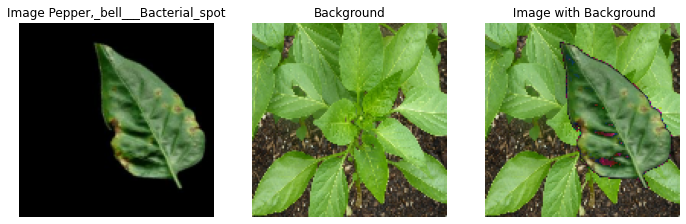

In [19]:
# Let's see an example:
# Get a random number
random = np.random.randint(0, len(df_info))

def get_img_bck(img_path, bckgrnd_path):
  """
  """
  # Threshold for background
  threshold = 10
  # Read the image file
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  # Resize image to our desired size
  img = tf.image.resize(img, IMG_SHAPE)

  bkg = tf.io.read_file(bckgrnd_path)
  bkg = tf.image.decode_jpeg(bkg, channels=3)
  # Resize image to our desired size
  bkg = tf.image.resize(bkg, IMG_SHAPE)
  # If pixel < threshold (ie=black background)
  # use pixel from backgound image, else use pixel of image (the leaf)
  n_img = tf.where(img < threshold, bkg, img)

  # Normalize image (cast float32 and image pixel between 0-1)
  return img, bkg, n_img

imgs_list = list(get_img_bck(df_info.iloc[random]['img_path'], df_info.iloc[random]['back_path']))

display_imgs(imgs_list, df_info.iloc[random]['plant___category'])

Split Data to Validation set and Train set.

In [20]:
train, valid = split_data(df_info)
print("Train df shape: ", train.shape)
print("Valid df shape: ", valid.shape)

Train df shape:  (88862, 6)
Valid df shape:  (22215, 6)


In [21]:
train['plant___category'].value_counts()

Orange___Haunglongbing_(Citrus_greening)              4382
Tomato___Tomato_Yellow_Leaf_Curl_Virus                4248
Soybean___healthy                                     4105
Tomato___Late_blight                                  3101
Squash___Powdery_mildew                               2969
Tomato___Septoria_leaf_spot                           2807
Tomato___Spider_mites Two-spotted_spider_mite         2672
Apple___healthy                                       2640
Tomato___healthy                                      2504
Blueberry___healthy                                   2416
Tomato___Early_blight                                 2395
Pepper,_bell___healthy                                2392
Potato___Early_blight                                 2369
Potato___Late_blight                                  2368
Pepper,_bell___Bacterial_spot                         2351
Corn_(maize)___Northern_Leaf_Blight                   2324
Tomato___Leaf_Mold                                    23

In [22]:
valid['plant___category'].value_counts()

Orange___Haunglongbing_(Citrus_greening)              1125
Tomato___Tomato_Yellow_Leaf_Curl_Virus                1109
Soybean___healthy                                      985
Tomato___Septoria_leaf_spot                            735
Tomato___Late_blight                                   717
Squash___Powdery_mildew                                701
Tomato___Spider_mites Two-spotted_spider_mite          680
Tomato___healthy                                       678
Apple___healthy                                        650
Pepper,_bell___Bacterial_spot                          640
Potato___Late_blight                                   632
Potato___Early_blight                                  631
Corn_(maize)___Northern_Leaf_Blight                    631
Tomato___Early_blight                                  605
Blueberry___healthy                                    588
Grape___Esca_(Black_Measles)                           571
Pepper,_bell___healthy                                 5

We have a distribution 80/20 for each plant category. And all category are present in each DataFrame.

### 4. Create Datasets

In [23]:
dataset_train = create_dataset(train)
dataset_valid = create_dataset(valid, valid_data=True)

Shape:  (88862,) 88862
Creation of the Training dataset...
Shape:  (22215,) 22215
Creation of the validation dataset...


Now that we have created our Train and Validation Dataset, let's visualise one batch or the Train Dataset to make sure it has the expected shape.

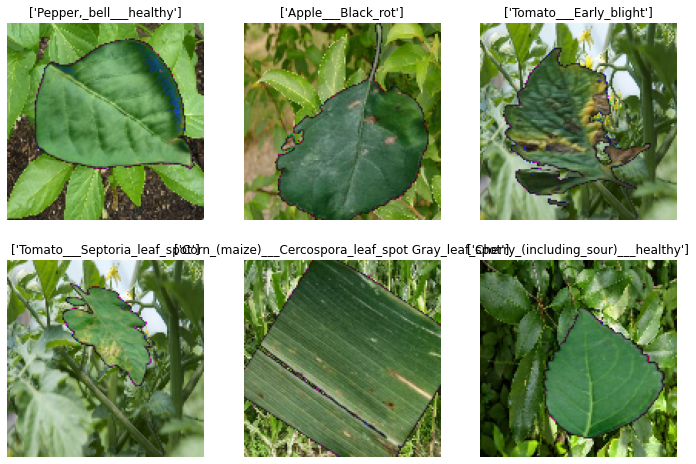

In [24]:
# Check if records are well created in datasets
img_batch, label_batch = next(iter(dataset_train))

plt.figure(figsize=(12, 8))
for i in range(6):
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow((img_batch[i].numpy()*255).astype("uint8"))
  label = label_batch[i]
  # Get the Label name from the Boolean list
  plt.title(unique_plant_cat[label])
  plt.axis("off")

We can see that our Batch is composed by:
- `img_batch` which represents our modified images with the background.
- `label_batch` which represent our labels.

We chose to only show 6 entries but each batch is composed of 32 images/labels pairs.

### 5. Create CNN model

We are creating our own CNN model composed by:
- 4 Conv2D layers with
    - Batch Normalisation
    - MaxPooling
    - ReLU activation
- 1 Flatten layer
- 2 Dense layers ReLU activation (and Dropout)
- 1 Final Dense layer with Softmax activation
> Return 39 probabilities, for each Classes we want to predict.


We specify the training configuration:
- We use `Adam optimizer` with Learning Rate of 0.0005. The choice of this learning rate have been made after multiple iteration. It allow the model to converge more quicker.
- We use `Categorical Crossentropy` loss function.  
- We will monitor our model with the `Accuracy` metric.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

NUM_EPOCHS = 20
INPUT_SHAPE = (128, 128, 3)
OUTPUT_SHAPE = 39

# Create model
# 4 conv2D layers
# Batch Normalisation and MaxPooling
def get_model():
  """
  Create a 4 Conv2D layers with
    - Batch Normalisation
    - MaxPooling
    - ReLU activation
  And 2 Dense layers ReLU activation (and Dropout)
  
  Return 39 probabilities (= number of plants + other category we want to predict) - activation Softmax
  """

  model = Sequential([
    # First CNN                     
    Conv2D(128, kernel_size=3, input_shape=INPUT_SHAPE, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    # Second CNN
    Conv2D(256, kernel_size=3, activation='relu'),   
    MaxPooling2D(),
    BatchNormalization(),
    # Third CNN
    Conv2D(512, kernel_size=3, activation='relu'), 
    MaxPooling2D(),
    BatchNormalization(),
    # Flatten last CNN output for Dense layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    # Return 38 probabilities (= number of plants we want to predict)
    Dense(OUTPUT_SHAPE, activation= 'softmax')
  ])

  return model

model = get_model()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show Summary 
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 512)       1

We will create two Callbacks:
- **Early stopping**: to stop training of the model if the validation accuracy is not moving down after 5 epochs.
- **Reduce Learning Rate**: To reduce the learning rate of Adam optimizer, if the Validation loss is not reducing after 3 epochs.

In [27]:

# Early stopping Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4)

# Reduce Learning rate Callbacks
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                   patience=3,
                                                   factor=0.2,
                                                   verbose=2,
                                                   mode='min')

### 6. Start Training model

Training on the whole dataset can take at least an hour. Once the training is done we will save the model, so we can use it or share it with anyone.



In [28]:
# Train Model
history = model.fit(x=dataset_train,
                  epochs=NUM_EPOCHS,
                  validation_data=dataset_valid,
                  callbacks=[early_stopping, lr_callback])

# Get Validation Loss and Accuracy
val_loss, val_acc = model.evaluate(dataset_valid)
val_acc = round(val_acc, 3)

# Save model
suffix = 'doctoplant_ep-'+str(NUM_EPOCHS)+'_img_acc_'+str(val_acc)+'-model_cnn'
save_model(model, suffix=suffix)



Epoch 1/20
2777/2777 [==============================] - 527s 186ms/step - loss: 2.2654 - accuracy: 0.5824 - val_loss: 0.7689 - val_accuracy: 0.6975
Epoch 2/20
2777/2777 [==============================] - 506s 181ms/step - loss: 0.6770 - accuracy: 0.7514 - val_loss: 0.4898 - val_accuracy: 0.8189
Epoch 3/20
2777/2777 [==============================] - 513s 183ms/step - loss: 0.4644 - accuracy: 0.8345 - val_loss: 0.5616 - val_accuracy: 0.8108
Epoch 4/20
2777/2777 [==============================] - 515s 184ms/step - loss: 0.2964 - accuracy: 0.8976 - val_loss: 0.3182 - val_accuracy: 0.9058
Epoch 5/20
2777/2777 [==============================] - 509s 182ms/step - loss: 0.2185 - accuracy: 0.9287 - val_loss: 0.2806 - val_accuracy: 0.9057
Epoch 6/20
2777/2777 [==============================] - 509s 182ms/step - loss: 0.1665 - accuracy: 0.9473 - val_loss: 0.2389 - val_accuracy: 0.9332
Epoch 7/20
2777/2777 [==============================] - 511s 183ms/step - loss: 0.1317 - accuracy: 0.9583 - val_

'drive/My Drive/DataScientest/30 - Models/saved_models/20210130-05321611984774-doctoplant_ep-20_img_acc_0.963-model_cnn.h5'

In [30]:
# Show model accuracy
print("Evaluation of the model...")
print(f"Model has a validation accuracy of {val_acc*100}%.")

Evaluation of the model...
Model has a validation accuracy of 96.3%.


In [32]:
# Save History
hist_df = pd.DataFrame(history.history) 

hist_csv_file = 'drive/My Drive/DataScientest/30 - Models/new_history_full_'+str(val_acc)+'20210130.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Evaluate Model

Now that the model has been trained, we can evaluate it and conclude about the good performance.

We will:
1. Evaluate the Loss and Accuracy of Train and Validation datasets
2. Show some predictions from the Validation set
3. Plot a Confusion Matrix to see which leaves are the most confused by the model
4. Show some wrong predictions and the probabilities associated

In [37]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_plant_cat[np.argmax(prediction_probabilities)]

# Create a function to unbatch a batch dataset
def unbatchify(batch_data):
    """
    Take batch data and return unbatch data (separate arrays of images and labels) in a form of a tuple of lists
    """
    img = []
    lbl = []
    for image, label in batch_data.unbatch().as_numpy_iterator():
        img.append(image*255)
        lbl.append(get_pred_label(label))

    return img,lbl

# Show images and prediction rate
def show_img_and_prediction(model, dataset_valid, nb_img=9):
    """
      Take model and validation dataset.
      Unbatch validation dataset to get the images and tru labels
      Show 9 random images with the 
        - predicted label (with the percent of prediction)
        - the image model tried to predict
        - the true label
    """
    # Get predictions
    predictions = model.predict(dataset_valid)
    # Get Validation datset images and true labels
    imgs, labels = unbatchify(dataset_valid)
    # Get 10 random images in the validation dataset
    img_rdm = np.random.randint(0, len(imgs), nb_img)

    plt.figure(figsize=(20,12))
    for idx, i in enumerate(img_rdm):
        color = 'red' # by default, color of the title is red

        plt.subplot(3,3,idx+1)
        plt.imshow(imgs[i].astype('uint8'))
        plt.xticks([])
        plt.yticks([])
        # If the predicted label is the same as the true label, change color of the title to green
        if get_pred_label(predictions[i]) == labels[i]:
            color = 'green'

        plt.title('Pred({}) : {} - {:2.0f}%'.format(i, get_pred_label(predictions[i]), np.max(predictions[i])*100), color=color)
        plt.xlabel('Real: {}'.format(labels[i]));  

# Plot Accuracy and Loss for both Training and Validation Dataset
def plot_acc_and_loss(history):
  """
  From Model History, plot two Graphs: 
   - Accuracy Train + Validation
   - Loss Train + Validation

  Input: model history
  """
  # Get Accuracy from History model
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  # Get Loss from History model
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss)+1)
  
  plt.figure(figsize=(16,8))
  # Accuracy subplot
  plt.subplot(121)
  plt.plot(epochs, acc, color='red', label='Training Accuracy')
  plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(epochs)
  plt.yticks(np.arange(0,1.1,0.1))
  plt.legend()

  # Loss subplot
  plt.subplot(122)
  plt.plot(epochs, loss, color='orange', label='Training Loss')
  plt.plot(epochs, val_loss, color='navy', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(epochs)
  plt.legend()


def plot_pred_prob(predictions, labels, n=1):
    """
    Show the top 3 highest prediction confidences along with the truth label for sample n.
    
    Inputs: 
      - predictions array 
      - labels array
      - n id of sample to check 
    """
    pred_prob, true_label = predictions[n], labels[n]

    # Get predicted label
    pred_label = get_pred_label(pred_prob)

    # Get top 3 prediction confidence indexes
    top_3_pred_indexes = pred_prob.argsort()[-3:][::-1]
    # Find the top 3 prediction confidence values
    top_3_pred_values = pred_prob[top_3_pred_indexes]
    # Find the top 3 prediction labels
    top_3_pred_labels = unique_plant_cat[top_3_pred_indexes]

    # Setup plot    
    top_plot = plt.barh(np.arange(len(top_3_pred_labels)),
                        top_3_pred_values,
                        color="grey")
    plt.yticks(np.arange(len(top_3_pred_labels)),
               labels=top_3_pred_labels,
               rotation="horizontal")
    plt.xlabel('Probability')
  
    # Change color of true label
    if np.isin(true_label, top_3_pred_labels):
        top_plot[np.argmax(top_3_pred_labels == true_label)].set_color("green")
        if top_3_pred_labels[0] != true_label:
            top_plot[0].set_color("red")
        else:
            pass


def get_wrong_preds(predictions, labels, n=9):
  """
  Show wrong predictions with 3 highest probabilities.
  This to help to know which plants the model has issue to distinguish and why.
  """
  pred_idx = []

  for i, pred_prob in enumerate(predictions):
    pred_label = get_pred_label(pred_prob)
    if pred_label != labels[i]:
      pred_idx.append(i)

    if len(pred_idx) >= n:
      return pred_idx

  return pred_idx

### 1. Plot Accuracy & Loss

- Plot Train and Validation Accuracy
- Plot Train and Validation Loss 

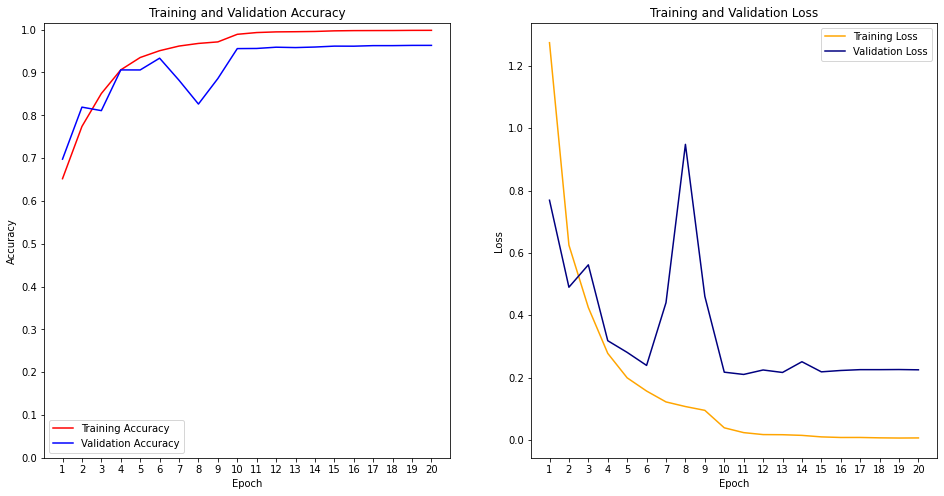

In [38]:
# Plot Accuracy & Loss
plot_acc_and_loss(history)

### 2. Predictions from Valid Dataset

From Validation Dataset:
- Show images and Predictions wiht probalities

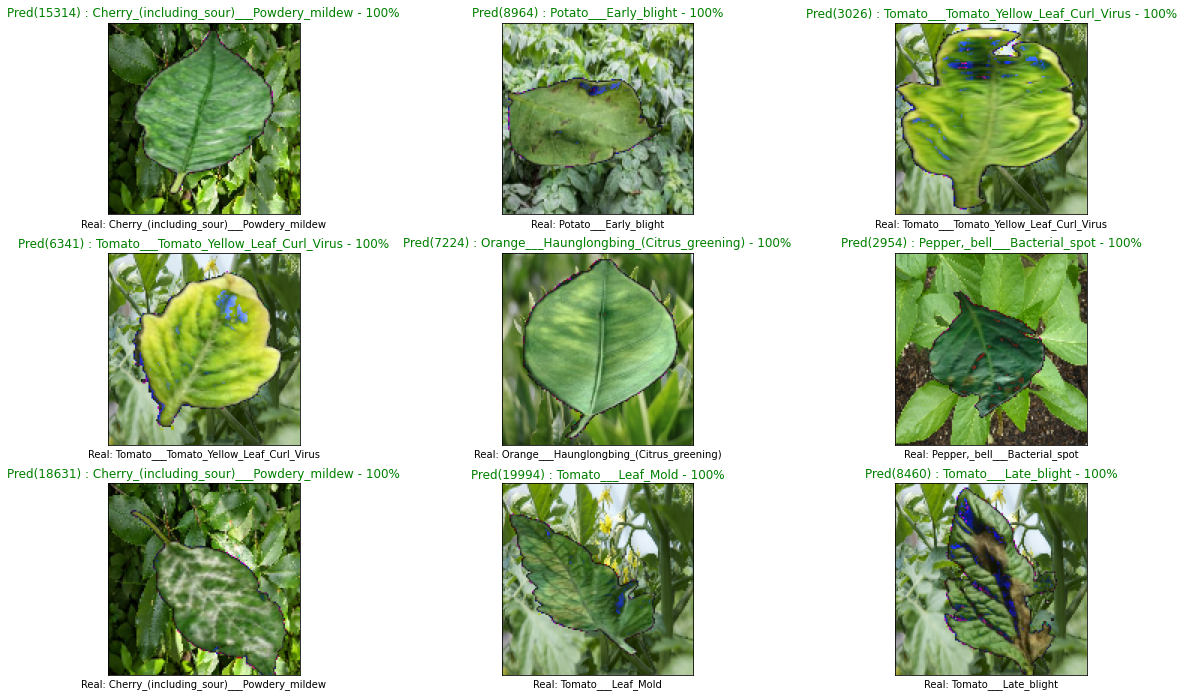

In [ ]:
show_img_and_prediction(model, dataset_valid)

### 3. Confusion Matrix

In [40]:
# Get predictions
predictions = model.predict(dataset_valid)
pred_labels = list(map(get_pred_label, predictions)) # Get predictions as a list of Plant Categories
# Get Validation dataset Images and True Labels
imgs, labels = unbatchify(dataset_valid)

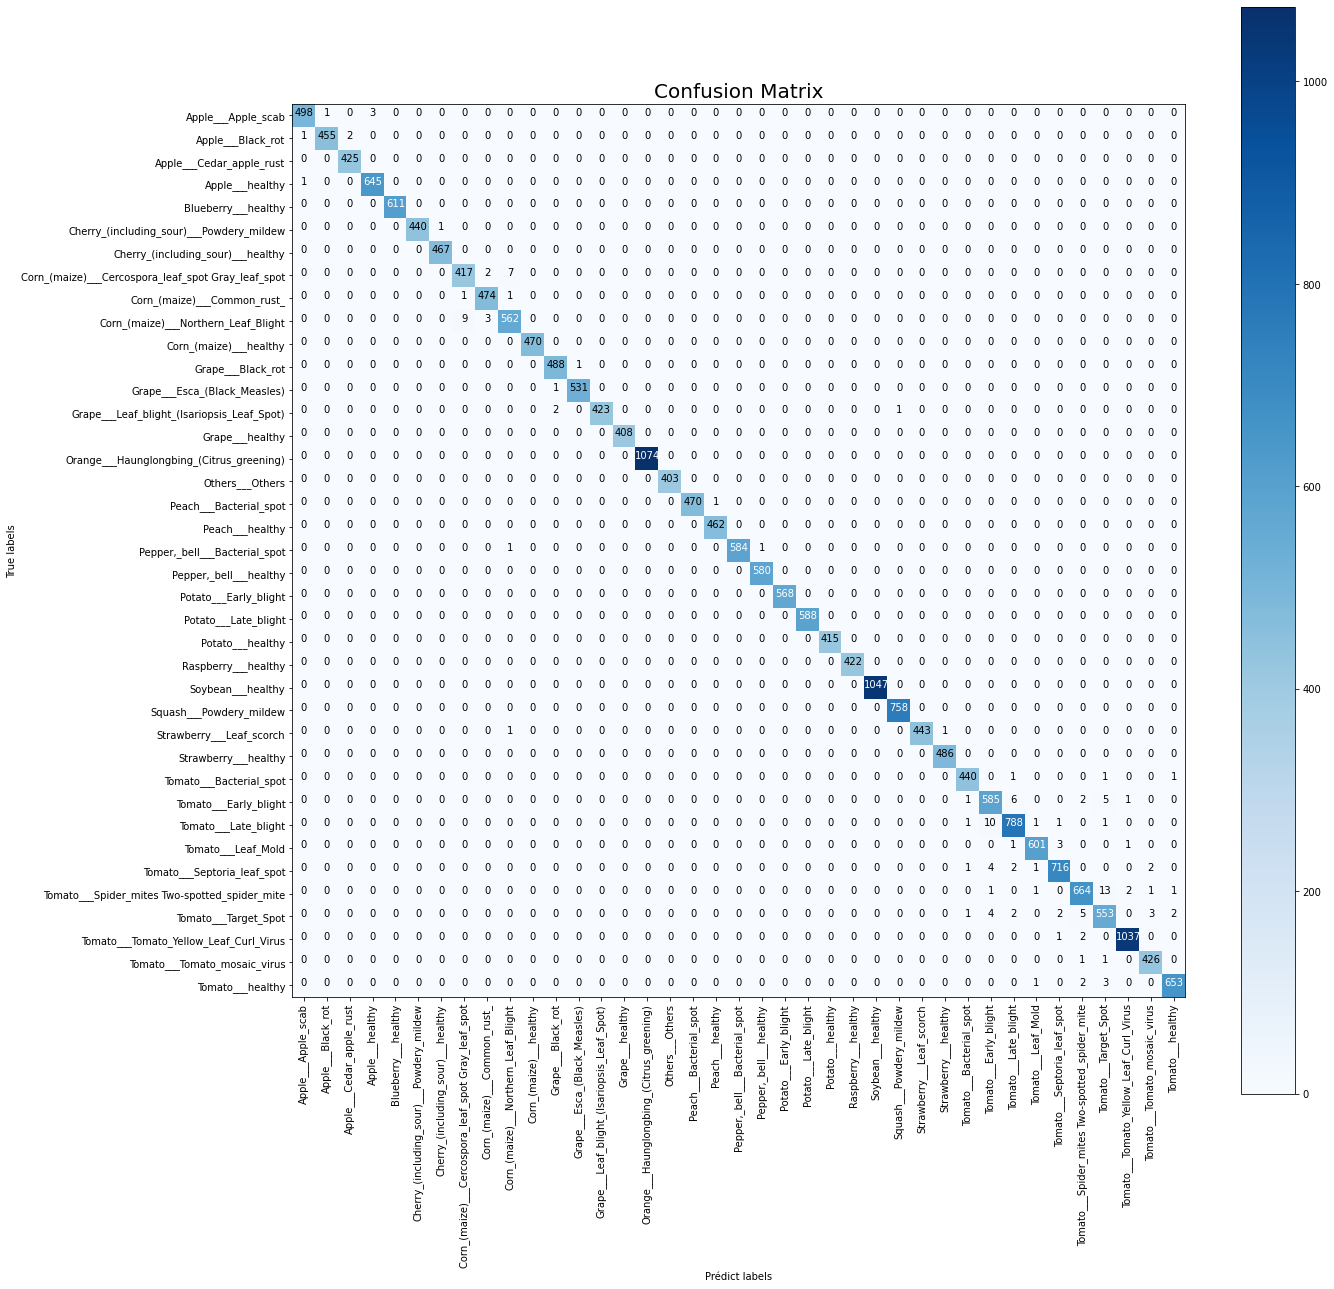

In [ ]:
# Import Required packages
from sklearn.metrics import confusion_matrix
import itertools

# Create COnfusion matrix
cnf_matrix = confusion_matrix(labels, pred_labels)
classes = range(0,10)

plt.figure(figsize=(20,20))
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix",fontsize=20)
plt.colorbar()
tick_marks = np.arange(len(unique_plant_cat))

plt.xticks(tick_marks, unique_plant_cat, rotation='vertical')
plt.yticks(tick_marks, unique_plant_cat)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predict labels')
plt.show()

### 4. Show wrong predictions

Get list of all wrong predictions

We can notice that most of the confusion in predicting the correct leaves are between the same species.


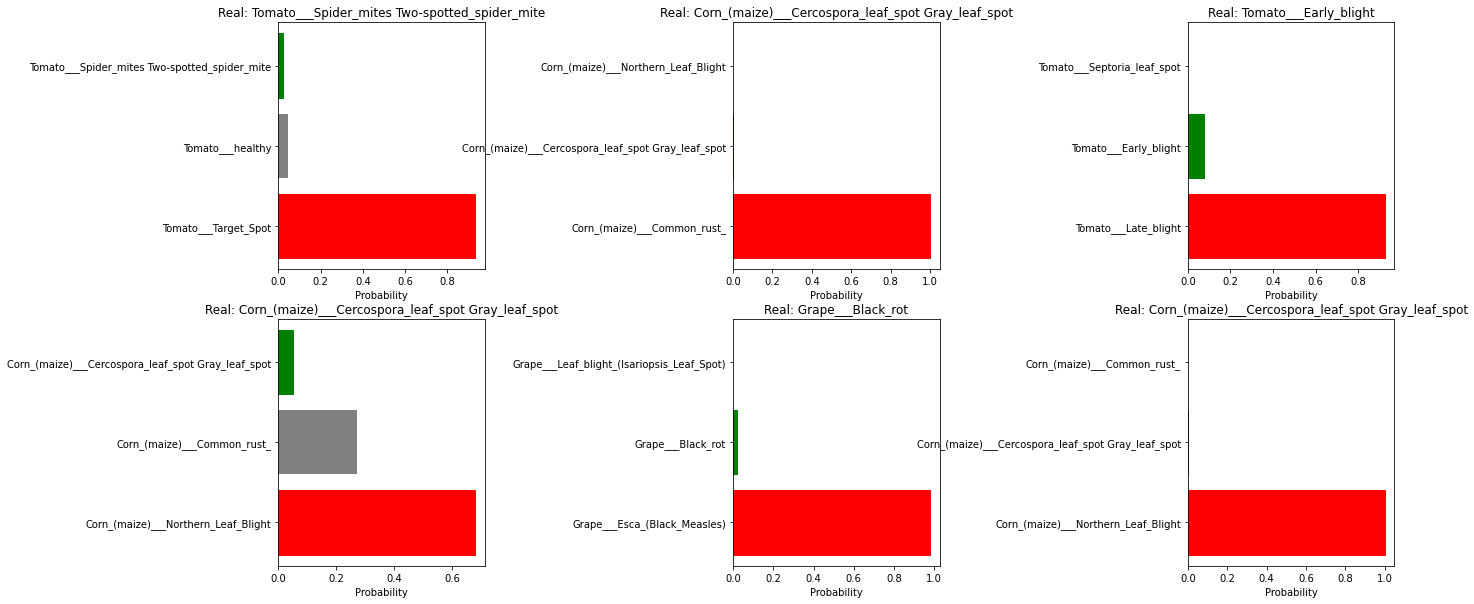

In [42]:
# Get list of wrong prediction
wrong_pred_idx = get_wrong_preds(predictions, labels, n=6)

# Show wrong predictions with top 3 probabilities
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace = 1.2)
for i, pred_idx in enumerate(wrong_pred_idx):
  plt.subplot(2,3,i+1)
  plot_pred_prob(predictions, labels, n=pred_idx)
  plt.title('Real: {}'.format(labels[pred_idx]))

print('We can notice that most of the confusion in predicting the correct leaves are between the same species.')

## What's Next?

Now that we validate our model, we should design a better application where the user can upload a picture of a plant, and the application should provide below information:
- What kind of plant?
- Is the plant healthy or diseased?
- If the plant is diseased, provide information about the disease itself.

Let's use **Streamlit**.